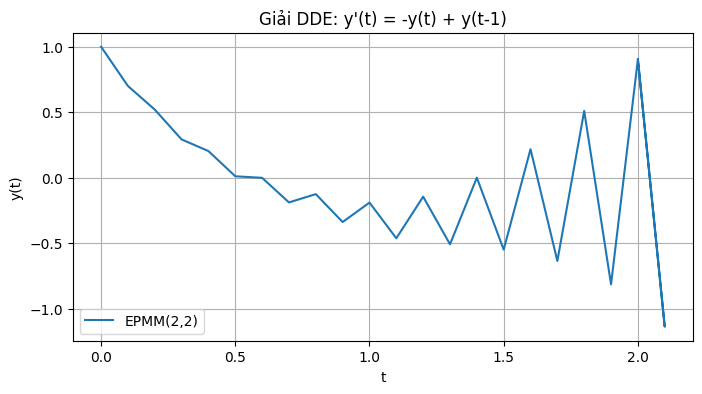

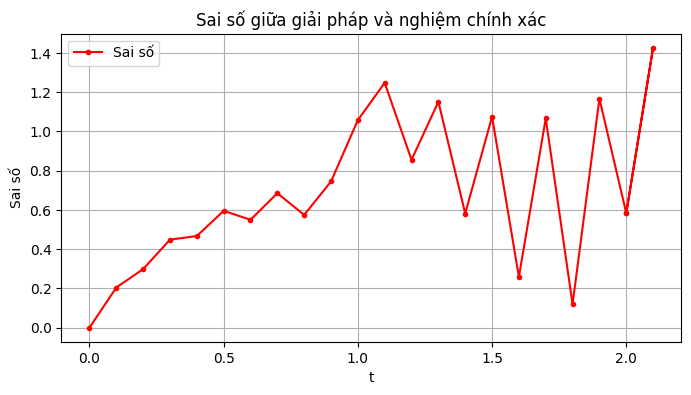

In [3]:
import numpy as np

def lagrange_interpolation(x_points, y_points, x):
    """
    Nội suy Lagrange trên tập các điểm (x_points, y_points) tại giá trị x.
    Công thức: P(x) = Σ y_i * Π_{j≠i} ((x - x_j)/(x_i - x_j))
    """
    n = len(x_points)
    result = 0.0
    for i in range(n):
        term = y_points[i]
        for j in range(n):
            if j != i:
                term *= (x - x_points[j]) / (x_points[i] - x_points[j])
        result += term
    return result

def get_y_at(s, t_vals, y_vals, phi, t0):
    """
    Hàm trả về giá trị y tại thời điểm s.
    Nếu s < t0 thì dùng hàm lịch sử phi(s).
    Nếu s nằm trong lưới {t_vals} thì trả về giá trị đã tính nếu trùng nút (với một sai số nhỏ)
    Nếu không trùng, sử dụng nội suy Lagrange dựa trên 2 hoặc 3 điểm lân cận.
    """
    # Nếu s nằm ngoài miền tính (ở quá khứ) -> dùng lịch sử
    if s < t0:
        return phi(s)
    
    # Kiểm tra xem s có trùng với một nút đã tính không
    for i, t_val in enumerate(t_vals):
        if abs(s - t_val) < 1e-12:
            return y_vals[i]
    
    # Nếu s nằm giữa các nút: tìm khoảng chứa s
    n_points = len(t_vals)
    # Nếu s nhỏ hơn nút đầu tiên (không thể xảy ra vì s>=t0) thì dùng phi(s)
    if s < t_vals[0]:
        return phi(s)
    
    # Tìm khoảng [t[i], t[i+1]] sao cho t[i] <= s <= t[i+1]
    for i in range(n_points - 1):
        if t_vals[i] <= s <= t_vals[i+1]:
            # Nếu có đủ điểm cho nội suy bậc 2 (3 điểm), ta chọn [t[i-1], t[i], t[i+1]]
            if i > 0 and i+1 < n_points:
                x_pts = [t_vals[i-1], t_vals[i], t_vals[i+1]]
                y_pts = [y_vals[i-1], y_vals[i], y_vals[i+1]]
                return lagrange_interpolation(x_pts, y_pts, s)
            else:
                # Nếu không đủ điểm, dùng nội suy tuyến tính
                x0, x1 = t_vals[i], t_vals[i+1]
                y0, y1 = y_vals[i], y_vals[i+1]
                return y0 + (y1 - y0) * (s - x0) / (x1 - x0)
    
    # Nếu s lớn hơn nút cuối, tiến hành ngoại suy tuyến tính
    x0, x1 = t_vals[-2], t_vals[-1]
    y0, y1 = y_vals[-2], y_vals[-1]
    return y0 + (y1 - y0) * (s - x0) / (x1 - x0)

def solve_dde_epmm(f, tau, phi, t0, t_end, h, tol=1e-6):
    """
    Giải phương trình vi phân trễ (DDE):
        y'(t) = f(t, y(t), y(t - tau(t,y(t))))
    với điều kiện ban đầu:
        y(t) = phi(t)   cho t <= t0
    sử dụng phương pháp 2-bước bậc 2 (EPMM(2,2)) theo công thức:
        y[n+2] = y[n] + 2h * f(t[n+1], y[n+1], y( t[n+1] - tau(t[n+1], y[n+1]) ))
    
    Input:
      - f: Hàm số f(t, y, y_delay).
      - tau: Hàm độ trễ tau(t, y) (có thể phụ thuộc vào t và y).
      - phi: Hàm lịch sử (initial history) cho t <= t0.
      - t0: Thời gian bắt đầu.
      - t_end: Thời gian kết thúc.
      - h: Kích thước bước.
      - tol: Sai số cục bộ mong muốn (chưa dùng để tự thích nghi trong ví dụ này).
    
    Output:
      - t_vals: Mảng các thời điểm.
      - y_vals: Giá trị gần đúng của y tại các thời điểm tương ứng.
    
    Lưu ý: Phương pháp này khởi tạo bằng một bước Euler để tính y₁ sau đó áp dụng đẳng thức hai bước.
    """
    t_vals = [t0]
    y_vals = [phi(t0)]
    
    # Bước khởi tạo: tính y₁ sử dụng Euler (vì cần 2 giá trị ban đầu cho phương pháp 2 bước)
    t1 = t0 + h
    # Khi tính f(t0,...), giá trị trễ: t0 - tau(t0, y0); vì t0 - tau <= t0 nên dùng phi
    y_delay0 = phi(t0 - tau(t0, y_vals[0]))
    f0 = f(t0, y_vals[0], y_delay0)
    y1 = y_vals[0] + h * f0
    t_vals.append(t1)
    y_vals.append(y1)
    
    # Vòng lặp chính: sử dụng đẳng thức 2 bước.
    # Ở mỗi bước, ta áp dụng:
    #   y[n+2] = y[n] + 2h * f( t[n+1], y[n+1], y( t[n+1]-tau(t[n+1], y[n+1]) ) )
    # và cập nhật thời gian: t[n+2] = t[n] + 2h  (tương đương với t[n+1] + h)
    while t_vals[-1] < t_end:
        # Chọn cặp giá trị (y_n, y_(n+1)) để tính y_(n+2)
        # Ở vòng lặp này, phần tử "n" được chọn là phần tử cách xa cuối 2 bước.
        n = len(t_vals) - 2
        
        # Lấy thời điểm giữa và giá trị trung gian
        t_mid = t_vals[n+1]  
        y_mid = y_vals[n+1]
        # Tính giá trị trễ tại t_mid: t_delayed = t_mid - tau(t_mid, y_mid)
        t_delay = t_mid - tau(t_mid, y_mid)
        y_delay = get_y_at(t_delay, t_vals, y_vals, phi, t0)
        
        # Tính f tại điểm trung gian
        f_mid = f(t_mid, y_mid, y_delay)
        
        # Áp dụng công thức đẳng thức: tính giá trị mới
        y_new = y_vals[n] + 2 * h * f_mid
        t_new = t_vals[n] + 2 * h  # (cũng có thể: t_mid + h)
        
        t_vals.append(t_new)
        y_vals.append(y_new)
    
    # Nếu t_end không trùng khớp với nút cuối, có thể nội suy để trả về giá trị tại t_end
    if abs(t_vals[-1] - t_end) > 1e-12:
        y_end = get_y_at(t_end, t_vals, y_vals, phi, t0)
        t_vals.append(t_end)
        y_vals.append(y_end)
    
    return np.array(t_vals), np.array(y_vals)

# Ví dụ sử dụng: giải một DDE mẫu
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # Ví dụ đơn giản: DDE với độ trễ hằng số
    # Giả sử phương trình: y'(t) = - y(t) + y(t - 1)
    # Hàm f và tau như sau:
    def f_example(t, y, y_delay):
        return -2*y -y_delay
    
    # Độ trễ: tau(t,y) = 1 (hằng số)
    def tau_example(t, y):
        return 1
    
    # Hàm lịch sử: cho t <= 0, giả sử y(t) = 1
    def phi_example(t):
        return 1
    def y_exact(t):
        return np.exp(-t) + 0.5 * np.exp(-(t-1)) * (t >= 1)  # nghiệm chính xác cho DDE này

    # Các thông số ban đầu
    t0 = 0.0
    t_end = 2.0
    h = 0.1  # bước nhỏ để đạt được độ chính xác tốt

    t_sol, y_sol = solve_dde_epmm(f_example, tau_example, phi_example, t0, t_end, h, tol=1e-6)
    
    # Vẽ đồ thị kết quả
    plt.figure(figsize=(8, 4))
    plt.plot(t_sol, y_sol, label="EPMM(2,2)")
    plt.xlabel("t")
    plt.ylabel("y(t)")
    plt.title("Giải DDE: y'(t) = -y(t) + y(t-1)")
    plt.legend()
    plt.grid(True)
    plt.show()
    # Hàm tính sai số
    def compute_error(t_sol, y_sol):
        y_exact_vals = y_exact(t_sol)
        errors = np.abs(y_sol - y_exact_vals)
        return errors
    # Hàm vẽ sai số
    def plot_error(t_sol, errors):
        plt.figure(figsize=(8, 4))
        plt.plot(t_sol, errors, 'r.-', label="Sai số")
        plt.xlabel("t")
        plt.ylabel("Sai số")
        plt.title("Sai số giữa giải pháp và nghiệm chính xác")
        plt.legend()
        plt.grid(True)
        plt.show()
    # Tính toán sai số
    errors = compute_error(t_sol, y_sol)
    # Vẽ sai số
    plot_error(t_sol, errors)
    


In [4]:
len(t_sol)

23